# F1 Prediction


The FIA Formula 1 World Championship, better known as Formula 1, F1 or Formula One, is the premier international motorsport competition and the most popular and prestigious motorsport championship in the world since 1950. The governing body is the Fédération Internationale de l'Automobile (FIA). Since September 2016, following the acquisition of Formula One Group, the American company Liberty Media has been responsible for managing and operating the championship.

The objective of this work is to carry out an analysis of the data collected from Formula 1 with the intention of making a predictive model about, for example, the winner of the Grand Prix or the podium.


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, make_scorer
from custom_cvs import VariableTimeSeriesSplit
from custom_scorers import balanced_accuracy_1interval

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Data Selection


The main source of data is from kaggle, specifically,

_Source: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020_

From these data, the datasets used are as follows

- results.csv
- drivers.csv
- constructors.csv
- races.csv
- circuits.csv
- status.csv
- driver_standings.csv
- constructor_standings.csv
- qualifying.csv

Therefore, the ones that remain unused are

- constructor_results.csv
- lap_times.csv
- pit_stops.csv
- seasons.csv
- sprint_results.csv

These data have been omitted either because they are not seen to be useful or are attributes that are acquired at the end of the race, i.e., they could be objective attributes.

Obviously, if the trained model is poor, such unused data sets will be revisited or, in other case, simply look for other data apart from kaggle.


In [2]:
results_df = pd.read_csv("./data/results.csv")
drivers_df = pd.read_csv("./data/drivers.csv")
constructors_df = pd.read_csv("./data/constructors.csv")
races_df = pd.read_csv("./data/races.csv")
circuits_df = pd.read_csv("./data/circuits.csv")
status_df = pd.read_csv("./data/status.csv")
driver_standings_df = pd.read_csv("./data/driver_standings.csv")
constructor_standings_df = pd.read_csv("./data/constructor_standings.csv")
qualifyings_df = pd.read_csv("./data/qualifying.csv")

df = pd.merge(results_df, drivers_df, how="left", on="driverId")
df = df.merge(constructors_df, how="left", on="constructorId")
df = df.merge(races_df, how="left", on="raceId")
df = df.merge(circuits_df, how="left", on="circuitId", suffixes=("", "_z"))
df = df.merge(status_df, how="left", on="statusId")
df = df.merge(driver_standings_df, how="left", on=["raceId", "driverId"])
df = df.merge(constructor_standings_df, how="left", on=["raceId", "constructorId"])
df = df.merge(
    qualifyings_df,
    how="left",
    on=["raceId", "driverId", "constructorId"],
    suffixes=("", "_u"),
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26080 entries, 0 to 26079
Data columns (total 72 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   resultId                26080 non-null  int64  
 1   raceId                  26080 non-null  int64  
 2   driverId                26080 non-null  int64  
 3   constructorId           26080 non-null  int64  
 4   number_x                26080 non-null  object 
 5   grid                    26080 non-null  int64  
 6   position_x              26080 non-null  object 
 7   positionText_x          26080 non-null  object 
 8   positionOrder           26080 non-null  int64  
 9   points_x                26080 non-null  float64
 10  laps                    26080 non-null  int64  
 11  time_x                  26080 non-null  object 
 12  milliseconds            26080 non-null  object 
 13  fastestLap              26080 non-null  object 
 14  rank                    26080 non-null

Once the datasets have been merged, repeated or useless attributes, such as identifiers, are eliminated. In addition, some of the attributes will be renamed to facilitate compression.


In [3]:
df = df.drop(
    [
        "resultId",
        "position_x",
        "positionText_x",
        "time_x",
        "driverId",
        "code",
        "forename",
        "surname",
        "url_x",
        "constructorId",
        "name_x",
        "url_y",
        "raceId",
        "url",
        "fp1_date",
        "fp1_time",
        "fp2_date",
        "fp2_time",
        "fp3_date",
        "fp3_time",
        "quali_date",
        "quali_time",
        "sprint_date",
        "sprint_time",
        "circuitId",
        "name",
        "url_z",
        "statusId",
        "driverStandingsId",
        "points_y",
        "position_y",
        "positionText_y",
        "constructorStandingsId",
        "positionText",
        "qualifyId",
        "number",
        "position_u",
    ],
    axis=1,
)

col_name = {
    "number_x": "carNumber",
    "grid": "positionGrid",
    "positionOrder": "positionFinal",
    "points_x": "pointsDriverEarned",
    "laps": "lapsCompleted",
    "milliseconds": "timeTakenInMillisec",
    "rank": "fastestLapRank",
    "fastestLapSpeed": "maxSpeed",
    "statusId": "status",
    "number_y": "driverNumber",
    "dob": "driverBirth",
    "nationality_x": "driverNationality",
    "nationality_y": "constructorNationality",
    "year": "raceYear",
    "round": "raceRound",
    "name_y": "grandPrix",
    "date": "raceDate",
    "time_y": "raceTime",
    "location": "circuitLocation",
    "country": "circuitCountry",
    "lat": "circuitLat",
    "lng": "circuitLng",
    "alt": "circuitAlt",
    "status": "driverStatus",
    "wins_x": "driverWins",
    "wins_y": "constructorWins",
    "points": "pointsConstructorEarned",
    "position": "constructorPosition",
}

df.rename(columns=col_name, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26080 entries, 0 to 26079
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   carNumber                26080 non-null  object 
 1   positionGrid             26080 non-null  int64  
 2   positionFinal            26080 non-null  int64  
 3   pointsDriverEarned       26080 non-null  float64
 4   lapsCompleted            26080 non-null  int64  
 5   timeTakenInMillisec      26080 non-null  object 
 6   fastestLap               26080 non-null  object 
 7   fastestLapRank           26080 non-null  object 
 8   fastestLapTime           26080 non-null  object 
 9   maxSpeed                 26080 non-null  object 
 10  driverRef                26080 non-null  object 
 11  driverNumber             26080 non-null  object 
 12  driverBirth              26080 non-null  object 
 13  driverNationality        26080 non-null  object 
 14  constructorRef        

## Transforming the data


Each data will be transformed to its corresponding data type. In addition, the times will be converted to milliseconds and two derived attributes will be created: the age of the current driver and when the race was run. Also, the string "\N" will be replaced by None, to determine the nulls in the object type data.


In [4]:
dates = ["driverBirth", "raceDate"]
for d in dates:
    df[d] = pd.to_datetime(df[d])

h_f, m_f = "%H:%M:%S", "%M:%S.%f"
times = [
    ("fastestLapTime", m_f),
    ("raceTime", h_f),
    ("q1", m_f),
    ("q2", m_f),
    ("q3", m_f),
]
for t, f in times:
    df[t] = pd.to_numeric(
        pd.to_timedelta(
            pd.to_datetime(df[t], format=f, errors="coerce").dt.time.to_numpy(dtype=str)
        ).total_seconds()
        * 1000
    )

numbers = [
    "carNumber",
    "positionGrid",
    "positionFinal",
    "pointsDriverEarned",
    "lapsCompleted",
    "timeTakenInMillisec",
    "fastestLap",
    "fastestLapRank",
    "maxSpeed",
    "driverNumber",
    "raceYear",
    "raceRound",
    "circuitLat",
    "circuitLng",
    "circuitAlt",
    "driverWins",
    "pointsConstructorEarned",
    "constructorPosition",
    "constructorWins",
]
for n in numbers:
    df[n] = pd.to_numeric(df[n], errors="coerce")

df["driverAgeToday"] = datetime.today().year - df["driverBirth"].dt.year
df["driverAgeAtRace"] = df["raceDate"].dt.year - df["driverBirth"].dt.year
df = df.drop(["driverBirth"], axis=1)
df = df.drop(["raceDate"], axis=1)

df = df.replace("\\N", None)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26080 entries, 0 to 26079
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   carNumber                26074 non-null  float64
 1   positionGrid             26080 non-null  int64  
 2   positionFinal            26080 non-null  int64  
 3   pointsDriverEarned       26080 non-null  float64
 4   lapsCompleted            26080 non-null  int64  
 5   timeTakenInMillisec      7250 non-null   float64
 6   fastestLap               7615 non-null   float64
 7   fastestLapRank           7831 non-null   float64
 8   fastestLapTime           7615 non-null   float64
 9   maxSpeed                 7615 non-null   float64
 10  driverRef                26080 non-null  object 
 11  driverNumber             5823 non-null   float64
 12  driverNationality        26080 non-null  object 
 13  constructorRef           26080 non-null  object 
 14  constructorNationality

## Missing Values


First, we will check the number of nulls in each column.


In [5]:
df.isnull().sum()

carNumber                      6
positionGrid                   0
positionFinal                  0
pointsDriverEarned             0
lapsCompleted                  0
timeTakenInMillisec        18830
fastestLap                 18465
fastestLapRank             18249
fastestLapTime             18465
maxSpeed                   18465
driverRef                      0
driverNumber               20257
driverNationality              0
constructorRef                 0
constructorNationality         0
raceYear                       0
raceRound                      0
grandPrix                      0
raceTime                   18469
circuitRef                     0
circuitLocation                0
circuitCountry                 0
circuitLat                     0
circuitLng                     0
circuitAlt                    60
driverStatus                   0
driverWins                   469
pointsConstructorEarned     1867
constructorPosition         1867
constructorWins             1867
q1        

We can see several nulls in several columns, three of them being the qualifying times. Being data that provide great information about how well a driver can be given a circuit days before the grand prix, for the treatment of nulls we can start focusing on these times.

Specifically, there are several nulls, since the currently known qualifiers did not exist until 2006, with minor modifications. Previously, it could be that there were no qualifiers at all, or that there were not all three. For example, see the following link from 2016 for a bit of history of the qualifiers and the grid.

_Source: https://www.formula1.com/en/latest/features/2016/3/deciding-the-grid-a-history-of-f1-qualifying-formats.html_

Likewise, we can see that this is also corroborated in the data.


In [6]:
first_q_not_null = ~(df["q1"].isnull())
second_q_not_null = ~(df["q2"].isnull())
third_q_not_null = ~(df["q3"].isnull())
mask = first_q_not_null & second_q_not_null & third_q_not_null

df[mask]["raceYear"].drop_duplicates().sort_values().to_numpy().reshape(-1, 1)

array([[2006],
       [2007],
       [2008],
       [2009],
       [2010],
       [2011],
       [2012],
       [2013],
       [2014],
       [2015],
       [2016],
       [2017],
       [2018],
       [2019],
       [2020],
       [2021],
       [2022],
       [2023]], dtype=int64)

Therefore, the model will be limited to training only from 2006 onwards.

Obviously, if we see that the model remains poor, we can change the range and study the behavior of the model.


In [7]:
df = df[df["raceYear"] >= 2006]

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber               1724
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                   60
driverStatus                  0
driverWins                   51
pointsConstructorEarned      18
constructorPosition          18
constructorWins              18
q1                          102
q2      

There are still some nulls, which is normal, since not all pilots run all the qualifying rounds. As the grid position is determined by the lowest possible time of the three qualifiers, it will be sufficient to replicate the times in those qualifiers that are null. If the first two races are run and not the third, one of the other two races will be randomly selected to fill the third.


In [8]:
mask = first_q_not_null & ~second_q_not_null & ~third_q_not_null
df.loc[mask, ["q2", "q3"]] = df.loc[mask, "q1"]

mask = first_q_not_null & second_q_not_null & ~third_q_not_null
df.loc[mask, "q3"] = df.loc[mask, ["q1", "q2"]].sample(axis=1).squeeze()

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber               1724
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                   60
driverStatus                  0
driverWins                   51
pointsConstructorEarned      18
constructorPosition          18
constructorWins              18
q1                          102
q2      

In the same way, there are still nulls, which will probably be those drivers who for some reason have not been able to run the qualifiers and will start in the last positions.


In [9]:
df[df["q1"].isnull()]["positionGrid"].drop_duplicates().sort_values().values

array([ 0, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], dtype=int64)

Ignoring the case of the value 0, which will be discussed later, we can see that these are indeed the last positions.

Therefore, the maximum time will be assigned, taking into account that it will be per race and not globally.


In [10]:
qualify_by_race = (
    df[["raceYear", "raceRound", "q1"]]
    .groupby(["raceYear", "raceRound"])
    .agg({"q1": "max"})
)

mask = ~first_q_not_null & ~second_q_not_null & ~third_q_not_null

mg = df.loc[mask]
mg = mg.join(qualify_by_race, how="left", on=["raceYear", "raceRound"], rsuffix="Max")
df.loc[mask, ["q1", "q2", "q3"]] = mg["q1Max"]

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber               1724
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                   60
driverStatus                  0
driverWins                   51
pointsConstructorEarned      18
constructorPosition          18
constructorWins              18
q1                            0
q2      

Once the nulls of the qualifiers have been resolved, we will move on to others.

The case of the grid positions that are 0, are special cases in which the FIA allows drivers who have not qualified to race. For example, in the third grand prix of the 2023 season, perez and bottas were allowed to race without qualifying, as shown in the following link

_Source: https://www.formula1.com/en/results.html/2023/races/1143/australia/starting-grid.html_

We can also see this in the data


In [11]:
race_last_year = df["raceYear"] == 2023
race_round_three = df["raceRound"] == 3
position_grid_zero = df["positionGrid"] == 0
mask = race_last_year & race_round_three & position_grid_zero

df[mask].head()

,carNumber,positionGrid,positionFinal,pointsDriverEarned,lapsCompleted,timeTakenInMillisec,fastestLap,fastestLapRank,fastestLapTime,maxSpeed,driverRef,driverNumber,driverNationality,constructorRef,constructorNationality,raceYear,raceRound,grandPrix,raceTime,circuitRef,circuitLocation,circuitCountry,circuitLat,circuitLng,circuitAlt,driverStatus,driverWins,pointsConstructorEarned,constructorPosition,constructorWins,q1,q2,q3,driverAgeToday,driverAgeAtRace
25884,11.0,0,5,11.0,58,9161691.0,53.0,1.0,80235.0,236.814,perez,11.0,Mexican,red_bull,Austrian,2023,3,Australian Grand Prix,18000000.0,albert_park,Melbourne,Australia,-37.8497,144.968,10.0,Finished,1.0,123.0,1.0,3.0,78714.0,78714.0,78714.0,34,33
25890,77.0,0,11,0.0,58,9164884.0,46.0,17.0,82233.0,231.060,bottas,77.0,Finnish,alfa,Swiss,2023,3,Australian Grand Prix,18000000.0,albert_park,Melbourne,Australia,-37.8497,144.968,10.0,Finished,0.0,6.0,8.0,0.0,78714.0,78714.0,78714.0,35,34


Then, as it is not known in which grid position they started, we will put the last positions.


In [12]:
last_grid_by_race = (
    df[["raceYear", "raceRound", "positionGrid"]]
    .groupby(["raceYear", "raceRound"])
    .agg({"positionGrid": lambda x: max(x) + 1})
)

mask = position_grid_zero
mg = df[mask]
mg = mg.join(last_grid_by_race, how="left", on=["raceYear", "raceRound"], rsuffix="Max")
df.loc[mask, "positionGrid"] = mg["positionGridMax"]

df["positionGrid"].drop_duplicates().sort_values().to_numpy()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

Regarding the circuits, we are missing information on the altitude of the following circuits


In [13]:
df[df["circuitAlt"].isnull()]["circuitRef"].drop_duplicates()

25340    losail
25480     miami
Name: circuitRef, dtype: object

Simply look up the altitude of these two circuits manually and enter them into the data set.


In [14]:
df.loc[df["circuitRef"] == "losail", "circuitAlt"] = 20
df.loc[df["circuitRef"] == "miami", "circuitAlt"] = 2

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber               1724
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                    0
driverStatus                  0
driverWins                   51
pointsConstructorEarned      18
constructorPosition          18
constructorWins              18
q1                            0
q2      

To solve the number of victories of the pilots, knowing that they are per season, i.e., they start at 0 per year, it is simple to calculate the nulls.


In [15]:
df = df.sort_values(by=["raceYear", "driverRef", "raceRound"]).reset_index(drop=True)

drivers = df[df["driverWins"].isnull()]["driverRef"].drop_duplicates().to_numpy()
j = df.columns.get_loc("driverWins")

for driver in drivers:
    mask = (df["driverRef"] == driver) & (df["driverWins"].isnull())
    indexes = df[mask].index
    for i in indexes:
        pdata, cdata = df.iloc[i - 1], df.iloc[i]
        if (
            pdata["driverRef"] != cdata["driverRef"]
            or pdata["raceYear"] != cdata["raceYear"]
        ):
            if cdata["positionFinal"] == 1:
                df.iloc[i, j] = 1
            else:
                df.iloc[i, j] = 0
        else:
            if cdata["positionFinal"] == 1:
                df.iloc[i, j] = pdata["driverWins"] + 1
            else:
                df.iloc[i, j] = pdata["driverWins"]

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber               1724
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                    0
driverStatus                  0
driverWins                    0
pointsConstructorEarned      18
constructorPosition          18
constructorWins              18
q1                            0
q2      

Regarding the three nulls related to the constructors, since they are a little more difficult to calculate, and since there are few of them, we will first study them manually.


In [16]:
proyection = [
    "raceYear",
    "raceRound",
    "constructorRef",
    "constructorWins",
    "pointsConstructorEarned",
    "constructorPosition",
    "driverRef",
    "driverStatus",
]

nulls = df[df["pointsConstructorEarned"].isnull()]
nulls.sort_values(by=["raceYear", "raceRound", "constructorRef"])[proyection]

,raceYear,raceRound,constructorRef,constructorWins,pointsConstructorEarned,constructorPosition,driverRef,driverStatus
864,2008,1,force_india,NaN,NaN,NaN,fisichella,Collision
1066,2008,1,force_india,NaN,NaN,NaN,sutil,Hydraulics
788,2008,1,honda,NaN,NaN,NaN,barrichello,Disqualified
824,2008,1,honda,NaN,NaN,NaN,button,Collision
842,2008,1,red_bull,NaN,NaN,NaN,coulthard,Collision
1120,2008,1,red_bull,NaN,NaN,NaN,webber,Collision
860,2008,1,super_aguri,NaN,NaN,NaN,davidson,Collision
1062,2008,1,super_aguri,NaN,NaN,NaN,sato,Transmission
882,2008,1,toyota,NaN,NaN,NaN,glock,Accident
1084,2008,1,toyota,NaN,NaN,NaN,trulli,Electrical


It can be seen that they have no wins or points as these are the first races of the seasons where the two drivers of the same constructor have not been able to finish the race. Therefore, for these two attributes will be filled with zeros.

Regarding the position, each constructor will be provided with the maximum, obviously, per race.


In [17]:
mask = ["constructorWins", "pointsConstructorEarned"]
df[mask] = df[mask].fillna(0)

last_ctor_by_race = (
    df[["raceYear", "raceRound", "constructorPosition"]]
    .groupby(["raceYear", "raceRound"])
    .agg({"constructorPosition": lambda x: max(x) + 1})
)


mask = df["constructorPosition"].isnull()


mg = df[mask]
mg = mg.join(last_ctor_by_race, how="left", on=["raceYear", "raceRound"], rsuffix="Max")
df.loc[mask, "constructorPosition"] = mg["constructorPositionMax"]

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber               1724
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                    0
driverStatus                  0
driverWins                    0
pointsConstructorEarned       0
constructorPosition           0
constructorWins               0
q1                            0
q2      

Finally, the driver numbers have yet to be specified. First we will see which are the drivers without numbers.


In [18]:
df[df["driverNumber"].isnull()]["driverRef"].drop_duplicates().to_numpy()

array(['albers', 'barrichello', 'coulthard', 'doornbos', 'fisichella',
       'heidfeld', 'ide', 'klien', 'liuzzi', 'michael_schumacher',
       'montagny', 'monteiro', 'montoya', 'ralf_schumacher', 'rosa',
       'sato', 'speed', 'trulli', 'villeneuve', 'webber', 'yamamoto',
       'davidson', 'kovalainen', 'markus_winkelhock', 'nakajima', 'wurz',
       'bourdais', 'glock', 'piquet_jr', 'alguersuari', 'badoer', 'buemi',
       'bruno_senna', 'chandhok', 'grassi', 'petrov', 'ambrosio',
       'karthikeyan', 'resta', 'pic', 'garde'], dtype=object)

Doing a little research, it's not just that these pilots are not numbered in the data set, but that they can't be found on the web either. For example, in the following link there is a compilation of numbers in which none appears.

_Source: https://en.wikipedia.org/wiki/List_of_Formula_One_driver_numbers_

For this reason, and bearing in mind that the numbers should not significantly influence the result, they will be provided with a possible random number, i.e., one that is in the range 2 to 99 without the 17, and, obviously, not already in use.


In [19]:
numbers = np.arange(2, 100, dtype=np.float64)
numbers = np.delete(numbers, np.where(numbers == 17.0))
numbers_by_year = (
    (df[~df["driverNumber"].isnull()][["raceYear", "driverNumber"]])
    .groupby(by="raceYear")
    .agg(
        {
            "driverNumber": lambda x: np.delete(
                numbers, np.where(np.isin(numbers, x))
            ).tolist()
        }
    )
)

drivers = df[df["driverNumber"].isnull()]["driverRef"].drop_duplicates().to_numpy()

for driver in drivers:
    mask = df["driverRef"] == driver
    first_year = df.loc[mask, "raceYear"].head(1).values[0]
    last_year = df.loc[mask, "raceYear"].tail(1).values[0]
    possible_numbers = numbers_by_year.loc[first_year, "driverNumber"]
    driver_number = np.random.choice(possible_numbers, 1)[0]
    df.loc[mask, "driverNumber"] = driver_number
    while first_year <= last_year:
        ls = numbers_by_year.loc[first_year, "driverNumber"]
        new_possible_numbers = np.delete(ls, np.where(ls == driver_number))
        numbers_by_year.loc[first_year, "driverNumber"] = new_possible_numbers
        first_year += 1

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber                  0
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                    0
driverStatus                  0
driverWins                    0
pointsConstructorEarned       0
constructorPosition           0
constructorWins               0
q1                            0
q2      

Finally, there are attributes that are known once the race is over, i.e., possible target attributes. As they will not be used for now, they will be left unprocessed, with a possible revision in the future if we need to add more attributes to improve the model or change prediction.


## Validation


For the validation of the model, it will be tested with different target attributes, specifically

- Final position of the driver
- Final position of the driver in a +-1 interval
- Final position of the driver in fixed intervals of size 3
- The driver is winner or not
- The driver is podium or not

In any case, we will first have to order the instances to carry out the training of the model.


In [20]:
df = df.sort_values(by=["raceYear", "raceRound"]).reset_index(drop=True)

On the other hand, training will be done with walkforward, whose scikit instance that implements it is TimeSeriesSplit.


In [21]:
X_tscv = pd.DataFrame([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]])
tscv = TimeSeriesSplit(n_splits=2, max_train_size=3, test_size=1)

for train, test in tscv.split(X_tscv):
    print("%s %s" % (train, test))

[1 2 3] [4]
[2 3 4] [5]


However, the time intervals offered by TimeSeriesSplit are fixed, i.e. there cannot be more instances in one interval than in another. In our case, we have that every F1 season there can be more or less instances due to the variation of the drivers as well as the number of races. This can be seen below


In [22]:
instances_per_year = df["raceYear"].value_counts(sort=False)
instances_per_year

raceYear
2006    396
2007    374
2008    368
2009    340
2010    456
2011    456
2012    480
2013    418
2014    407
2015    378
2016    462
2017    400
2018    420
2019    420
2020    340
2021    440
2022    440
2023    240
Name: count, dtype: int64

Therefore, another class has been created extending TimeSeriesSplit that allows the variation of instances in each of the intervals, VariableTimeSeriesSplit. It has been created in an external file so as not to dirty the notebook.

First, let's see that the behavior is the same with the same parameters called above with TimeSeriesSplit.


In [23]:
tscv = VariableTimeSeriesSplit(n_splits=2, max_train_size=3, test_size=1)

for train, test in tscv.split(X_tscv):
    print("%s %s" % (train, test))

[1 2 3] [4]
[2 3 4] [5]


Now we will check the case of F1 seasons.


In [24]:
n_splits = len(instances_per_year) - 5
max_train_size = [instances_per_year[i : 5 + i].sum() for i in range(n_splits)]
test_size = instances_per_year[5:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

get_years = lambda x: ",".join(
    df.iloc[x]["raceYear"].drop_duplicates().to_numpy(dtype=str)
)

for i, (tr, ts) in enumerate(tscv.split(df)):
    print(f"Split {i+1}-th:")
    print(f"-> Train years (from {tr[0]} to {tr[len(tr)-1]}): {get_years(tr)}")
    print(f"-> Test years (from {ts[0]} to {ts[len(ts)-1]}): {get_years(ts)}")
    print()

Split 1-th:
-> Train years (from 0 to 1933): 2006,2007,2008,2009,2010
-> Test years (from 1934 to 2389): 2011

Split 2-th:
-> Train years (from 396 to 2389): 2007,2008,2009,2010,2011
-> Test years (from 2390 to 2869): 2012

Split 3-th:
-> Train years (from 770 to 2869): 2008,2009,2010,2011,2012
-> Test years (from 2870 to 3287): 2013

Split 4-th:
-> Train years (from 1138 to 3287): 2009,2010,2011,2012,2013
-> Test years (from 3288 to 3694): 2014

Split 5-th:
-> Train years (from 1478 to 3694): 2010,2011,2012,2013,2014
-> Test years (from 3695 to 4072): 2015

Split 6-th:
-> Train years (from 1934 to 4072): 2011,2012,2013,2014,2015
-> Test years (from 4073 to 4534): 2016

Split 7-th:
-> Train years (from 2390 to 4534): 2012,2013,2014,2015,2016
-> Test years (from 4535 to 4934): 2017

Split 8-th:
-> Train years (from 2870 to 4934): 2013,2014,2015,2016,2017
-> Test years (from 4935 to 5354): 2018

Split 9-th:
-> Train years (from 3288 to 5354): 2014,2015,2016,2017,2018
-> Test years (from 

Finally, before we start training the models with each target attribute, we have to encode the categorical attributes of the dataframe.


In [25]:
X = df.drop(
    [
        "positionFinal",
        "pointsDriverEarned",
        "lapsCompleted",
        "timeTakenInMillisec",
        "fastestLap",
        "fastestLapRank",
        "fastestLapTime",
        "maxSpeed",
        "driverStatus",
        "pointsConstructorEarned",
        "constructorPosition",
    ],
    axis=1,
)

enc = LabelEncoder()
for c in X.columns:
    if X[c].dtype == "object":
        X[c] = enc.fit_transform(X[c])

We will also create a function to facilitate the testing of the models.


In [26]:
def model_test(
    model,
    X,
    y,
    cv,
    *,
    scorers=["balanced_accuracy", "f1_micro"],
    n_repeats=1,
    interval=None,
    labels=None,
):

    print(model, "=" * 50, "\n")

    for scorer in scorers:
        scores = np.array(
            [
                cross_val_score(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)
                for _ in range(n_repeats)
            ]
        )
        scores = scores.flatten()
        print(f"CV with {scorer}:", scores.sum() / len(scores))

    splits = [
        (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])
        for (train, test) in cv.split(X)
    ]

    y_tests, y_preds = np.array([], dtype=np.int32), np.array([], dtype=np.int32)

    for split in splits:
        X_train, X_test, y_train, y_test = split
        model.fit(X_train, y_train)
        y_tests = np.append(y_tests, y_test.values)
        y_preds = np.append(y_preds, model.predict(X_test))

    if interval is not None:
        y_preds = np.where(np.abs(y_tests - y_preds) <= interval, y_tests, y_preds)

    if labels is not None:
        y_tests, y_preds = labels[y_tests], labels[y_preds]

    print("\n", classification_report(y_tests, y_preds, labels=labels))
    _, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(
        y_tests, y_preds, xticks_rotation="vertical", ax=ax, labels=labels
    )

The first objective attribute to be addressed will be the final position of each driver.


In [27]:
y = df["positionFinal"]

KNeighborsClassifier(metric='cosine', n_neighbors=6) ================================================== 



CV with balanced_accuracy: 0.06418235058714936
CV with f1_micro: 0.06423646070317898

               precision    recall  f1-score   support

           1       0.08      0.34      0.13       252
           2       0.08      0.13      0.10       252
           3       0.07      0.12      0.09       252
           4       0.06      0.07      0.06       252
           5       0.05      0.07      0.06       252
           6       0.05      0.05      0.05       252
           7       0.06      0.07      0.07       252
           8       0.06      0.06      0.06       252
           9       0.07      0.06      0.07       252
          10       0.03      0.02      0.03       252
          11       0.06      0.05      0.06       252
          12       0.07      0.04      0.05       252
          13       0.03      0.02      0.02       252
          14       0.05      0.03      0.04       252
          15       0.06      0.03      0.04       252
          16       0.07      0.04      0.05     

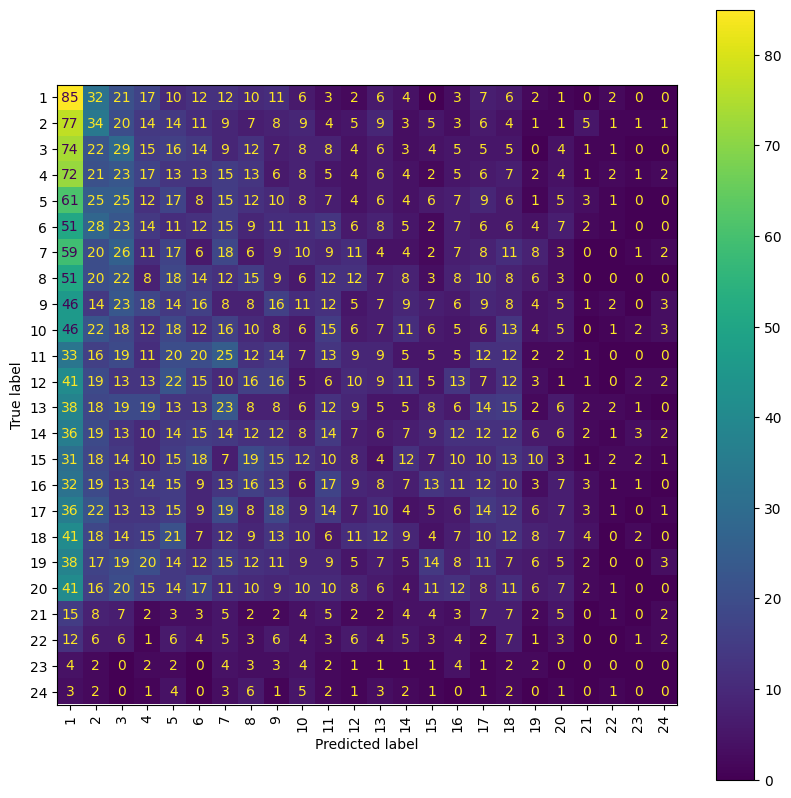

In [28]:
knn = KNeighborsClassifier(n_neighbors=6, metric="cosine")
model_test(knn, X, y, tscv)

DecisionTreeClassifier(criterion='entropy', max_depth=5) ================================================== 

CV with balanced_accuracy: 0.13428208530375713
CV with f1_micro: 0.1345522213633669

               precision    recall  f1-score   support

           1       0.49      0.71      0.58       252
           2       0.18      0.20      0.19       252
           3       0.17      0.27      0.21       252
           4       0.15      0.20      0.17       252
           5       0.09      0.09      0.09       252
           6       0.13      0.12      0.12       252
           7       0.10      0.20      0.14       252
           8       0.09      0.06      0.08       252
           9       0.06      0.07      0.06       252
          10       0.07      0.05      0.06       252
          11       0.05      0.09      0.07       252
          12       0.09      0.25      0.13       252
          13       0.07      0.02      0.03       252
          14       0.10      0.06      0.07    

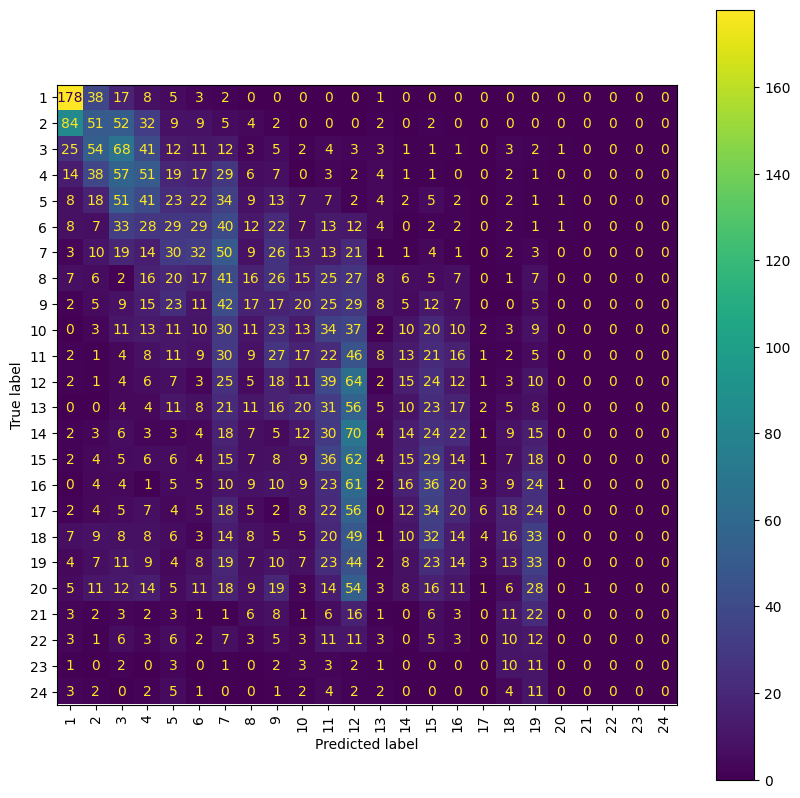

In [29]:
tree = DecisionTreeClassifier(max_depth=5, criterion="entropy")
model_test(tree, X, y, tscv, n_repeats=5)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10) ================================================== 

CV with balanced_accuracy: 0.12607150864271607
CV with f1_micro: 0.1249806856184565

               precision    recall  f1-score   support

           1       0.36      0.80      0.49       252
           2       0.17      0.18      0.17       252
           3       0.13      0.13      0.13       252
           4       0.08      0.09      0.08       252
           5       0.08      0.08      0.08       252
           6       0.10      0.13      0.11       252
           7       0.07      0.08      0.07       252
           8       0.07      0.06      0.06       252
           9       0.09      0.09      0.09       252
          10       0.06      0.04      0.05       252
          11       0.05      0.06      0.06       252
          12       0.09      0.13      0.10       252
          13       0.07      0.08      0.07       252
          14       0.07      0

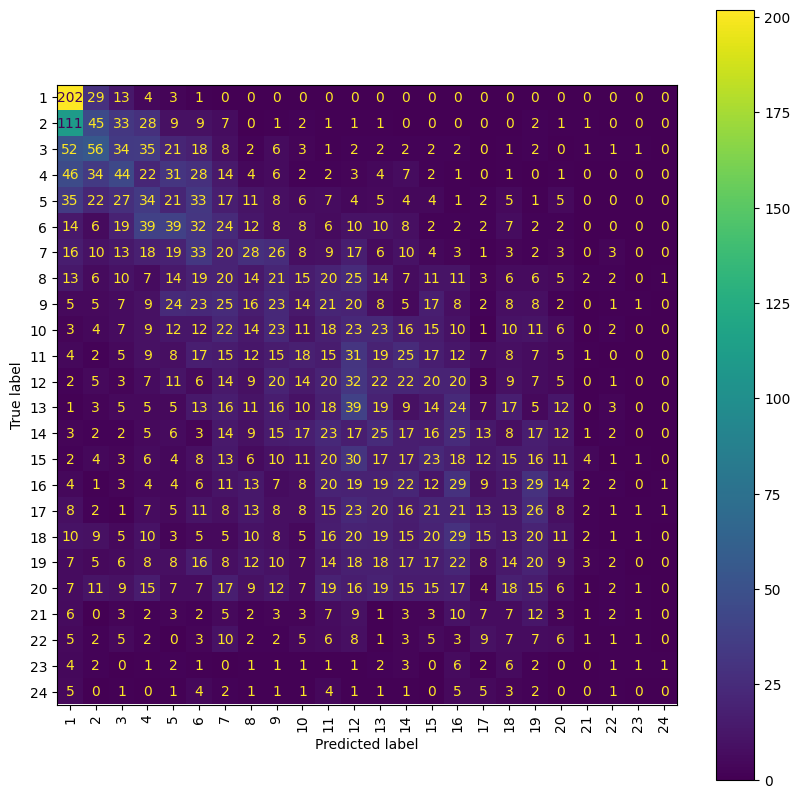

In [30]:
random_forest = RandomForestClassifier(
    n_estimators=10, max_depth=5, criterion="entropy"
)
model_test(random_forest, X, y, tscv, n_repeats=5)

MLPClassifier(activation='logistic', hidden_layer_sizes=(10, 5, 3)) ================================================== 

CV with balanced_accuracy: 0.04766899766899767
CV with f1_micro: 0.047632647632647636

               precision    recall  f1-score   support

           1       0.00      0.00      0.00       252
           2       0.04      0.08      0.05       252
           3       0.04      0.16      0.07       252
           4       0.05      0.08      0.06       252
           5       0.00      0.00      0.00       252
           6       0.00      0.00      0.00       252
           7       0.00      0.00      0.00       252
           8       0.05      0.08      0.06       252
           9       0.00      0.00      0.00       252
          10       0.00      0.00      0.00       252
          11       0.00      0.00      0.00       252
          12       0.05      0.09      0.06       252
          13       0.05      0.08      0.06       252
          14       0.05      0.23 

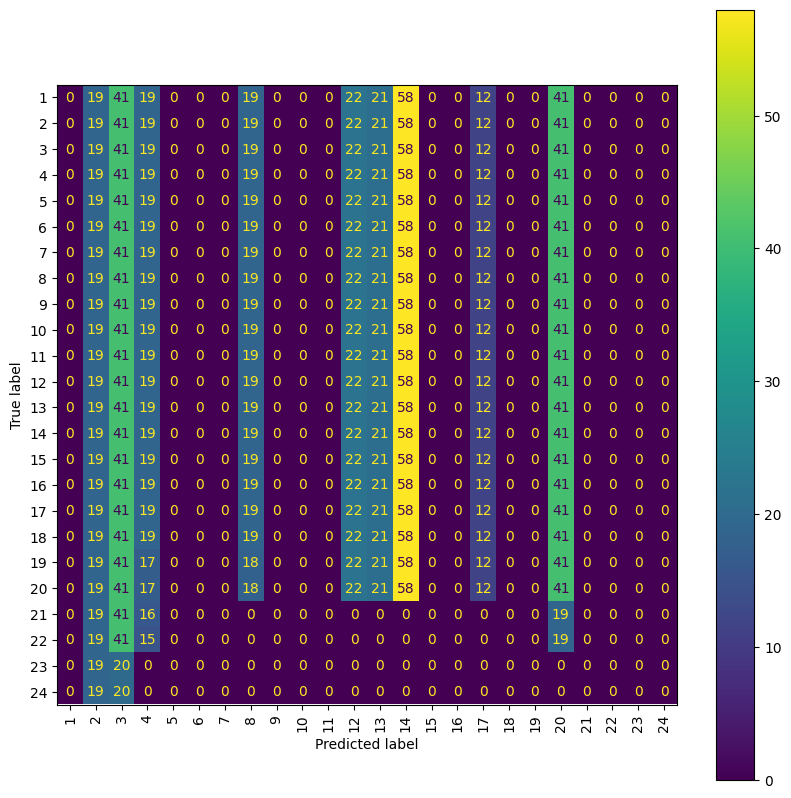

In [31]:
nn = MLPClassifier(hidden_layer_sizes=(10, 5, 3), activation="logistic")
model_test(nn, X, y, tscv, n_repeats=5)

The second objective attribute to be addressed will be the final position in a +-1 interval of each driver.


In [32]:
y = df["positionFinal"]

KNeighborsClassifier(metric='manhattan', n_neighbors=2) ================================================== 

CV with make_scorer(balanced_accuracy_1interval): 0.17753665108541267

               precision    recall  f1-score   support

           1       0.11      0.48      0.18       252
           2       0.32      0.50      0.39       252
           3       0.23      0.25      0.24       252
           4       0.21      0.21      0.21       252
           5       0.14      0.14      0.14       252
           6       0.15      0.10      0.12       252
           7       0.16      0.14      0.15       252
           8       0.16      0.13      0.14       252
           9       0.19      0.14      0.16       252
          10       0.18      0.13      0.15       252
          11       0.17      0.18      0.17       252
          12       0.18      0.17      0.17       252
          13       0.20      0.18      0.19       252
          14       0.15      0.17      0.16       252
        

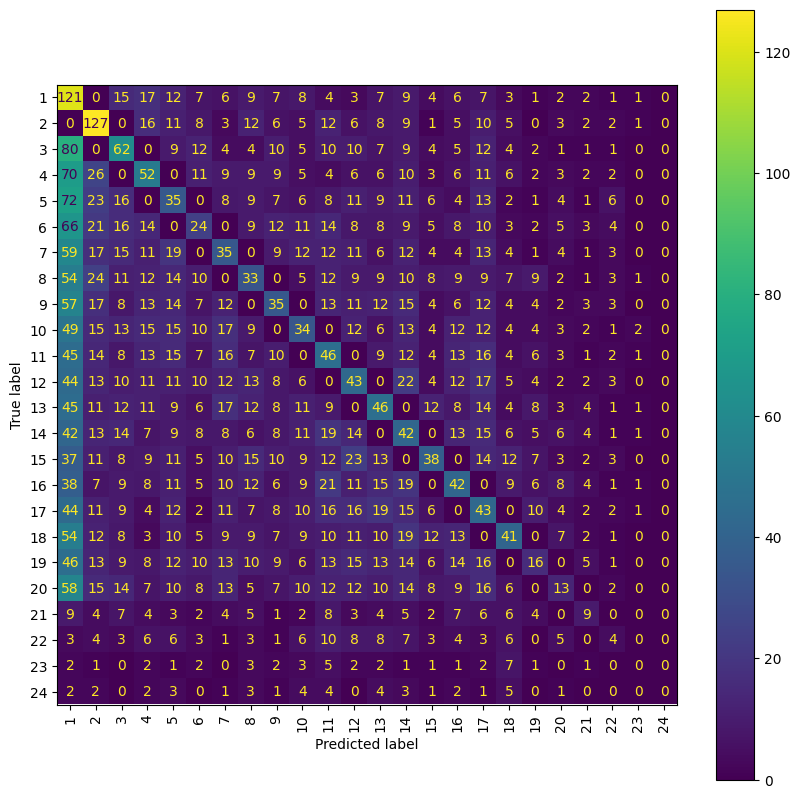

In [33]:
knn = KNeighborsClassifier(n_neighbors=2, metric="manhattan")
model_test(
    knn, X, y, tscv, scorers=[make_scorer(balanced_accuracy_1interval)], interval=1
)

DecisionTreeClassifier(criterion='entropy', max_depth=4) ================================================== 

CV with make_scorer(balanced_accuracy_1interval): 0.3339283433284981

               precision    recall  f1-score   support

           1       0.63      0.85      0.73       252
           2       0.62      0.76      0.68       252
           3       0.41      0.62      0.49       252
           4       0.37      0.43      0.40       252
           5       0.34      0.33      0.33       252
           6       0.35      0.43      0.39       252
           7       0.23      0.43      0.30       252
           8       0.45      0.30      0.36       252
           9       0.23      0.21      0.22       252
          10       0.36      0.33      0.35       252
          11       0.14      0.33      0.20       252
          12       0.26      0.40      0.32       252
          13       0.33      0.21      0.26       252
          14       0.27      0.25      0.26       252
        

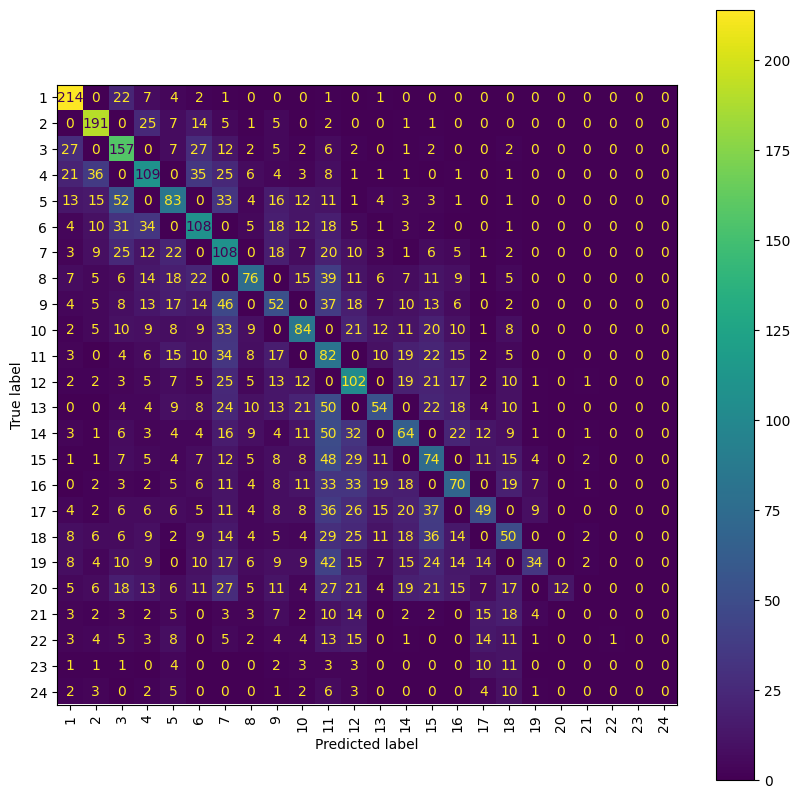

In [34]:
tree = DecisionTreeClassifier(max_depth=4, criterion="entropy")
model_test(
    tree,
    X,
    y,
    tscv,
    scorers=[make_scorer(balanced_accuracy_1interval)],
    interval=1,
    n_repeats=5,
)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=20) ================================================== 

CV with make_scorer(balanced_accuracy_1interval): 0.31971435126620884

               precision    recall  f1-score   support

           1       0.42      0.95      0.58       252
           2       0.66      0.77      0.71       252
           3       0.50      0.46      0.48       252
           4       0.33      0.38      0.35       252
           5       0.39      0.38      0.39       252
           6       0.27      0.35      0.30       252
           7       0.29      0.34      0.31       252
           8       0.30      0.23      0.26       252
           9       0.29      0.21      0.24       252
          10       0.28      0.19      0.23       252
          11       0.26      0.31      0.28       252
          12       0.19      0.37      0.25       252
          13       0.25      0.31      0.28       252
          14       0.22      0.15      0.18 

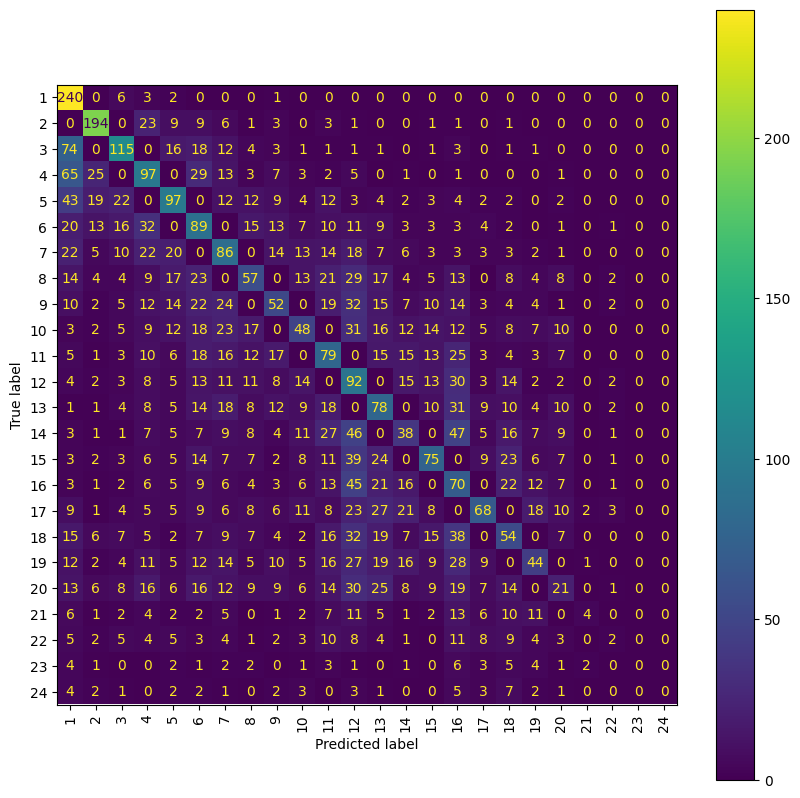

In [35]:
random_forest = RandomForestClassifier(
    n_estimators=20, max_depth=4, criterion="entropy"
)
model_test(
    random_forest,
    X,
    y,
    tscv,
    scorers=[make_scorer(balanced_accuracy_1interval)],
    interval=1,
    n_repeats=5,
)

MLPClassifier(activation='logistic', hidden_layer_sizes=(60, 30)) ================================================== 

CV with make_scorer(balanced_accuracy_1interval): 0.1406993006993007

               precision    recall  f1-score   support

           1       1.00      0.08      0.14       252
           2       0.05      0.08      0.06       252
           3       1.00      0.08      0.14       252
           4       0.00      0.00      0.00       252
           5       0.00      0.00      0.00       252
           6       1.00      0.08      0.15       252
           7       0.15      0.24      0.18       252
           8       0.10      0.32      0.15       252
           9       0.13      0.23      0.17       252
          10       1.00      0.08      0.14       252
          11       1.00      0.05      0.09       252
          12       0.25      0.27      0.26       252
          13       0.07      0.27      0.11       252
          14       1.00      0.23      0.37       252

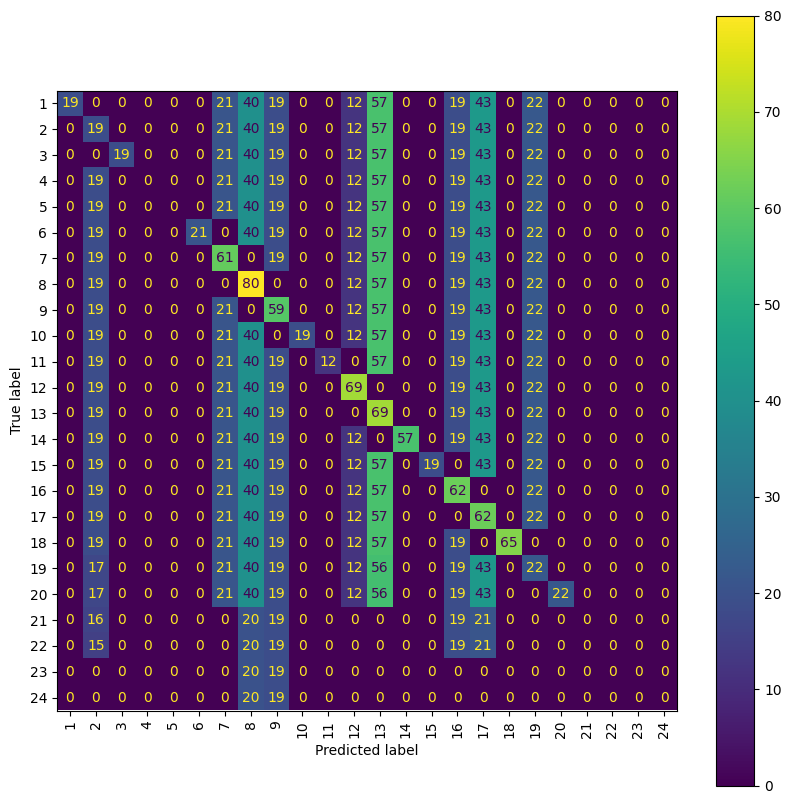

In [36]:
nn = MLPClassifier(hidden_layer_sizes=(60, 30), activation="logistic")
model_test(
    nn,
    X,
    y,
    tscv,
    scorers=[make_scorer(balanced_accuracy_1interval)],
    interval=1,
    n_repeats=5,
)

The third objective attribute to be addressed will be the final position in fixed intervals of size 3.


In [37]:
max_pos = df["positionFinal"].max() + 1
intervals = np.array([f"{x}-{x+2}" for x in np.arange(1, max_pos, 3)])
y = df["positionFinal"].map(lambda x: np.ceil(x / 3 - 1).astype(np.int32))

KNeighborsClassifier(metric='manhattan', n_neighbors=2) ================================================== 

CV with balanced_accuracy: 0.18000857176387913
CV with f1_micro: 0.18850557737167642

               precision    recall  f1-score   support

         1-3       0.22      0.52      0.31       756
         4-6       0.17      0.15      0.16       756
         7-9       0.16      0.13      0.14       756
       10-12       0.16      0.15      0.15       756
       13-15       0.18      0.16      0.17       756
       16-18       0.21      0.17      0.19       756
       19-21       0.16      0.06      0.09       593
       22-24       0.02      0.01      0.01       172

    accuracy                           0.19      5301
   macro avg       0.16      0.17      0.15      5301
weighted avg       0.18      0.19      0.17      5301



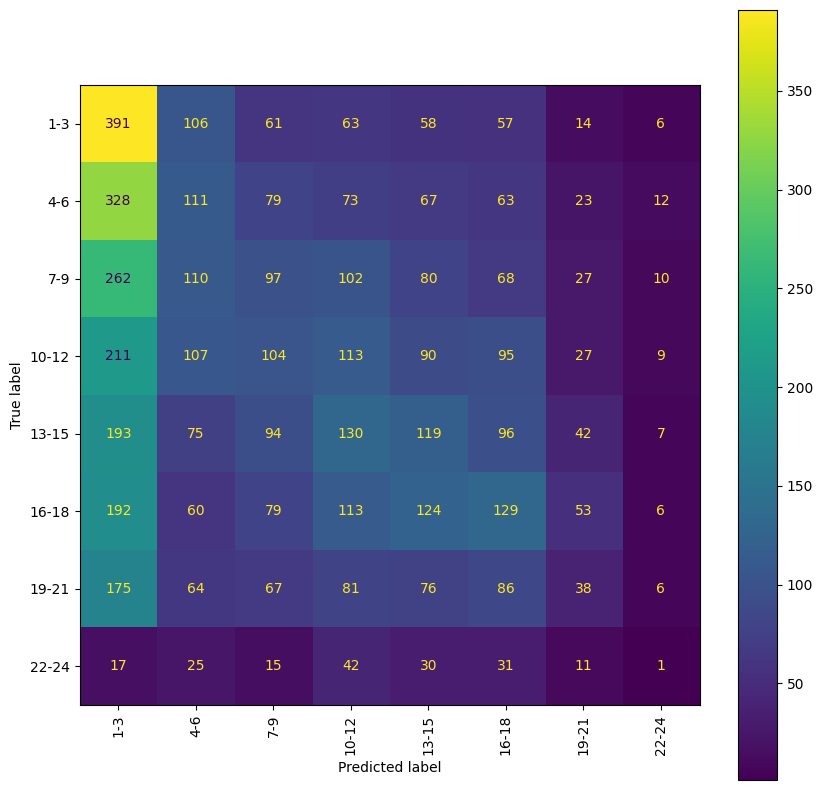

In [38]:
knn = KNeighborsClassifier(n_neighbors=2, metric="manhattan")
model_test(knn, X, y, tscv, labels=intervals)

DecisionTreeClassifier(criterion='entropy', max_depth=4) ================================================== 

CV with balanced_accuracy: 0.3198318327453666
CV with f1_micro: 0.336250025855289

               precision    recall  f1-score   support

         1-3       0.60      0.72      0.65       756
         4-6       0.36      0.40      0.38       756
         7-9       0.26      0.39      0.31       756
       10-12       0.22      0.31      0.26       756
       13-15       0.27      0.31      0.28       756
       16-18       0.35      0.17      0.23       756
       19-21       0.38      0.09      0.14       593
       22-24       0.00      0.00      0.00       172

    accuracy                           0.34      5301
   macro avg       0.31      0.30      0.28      5301
weighted avg       0.34      0.34      0.32      5301



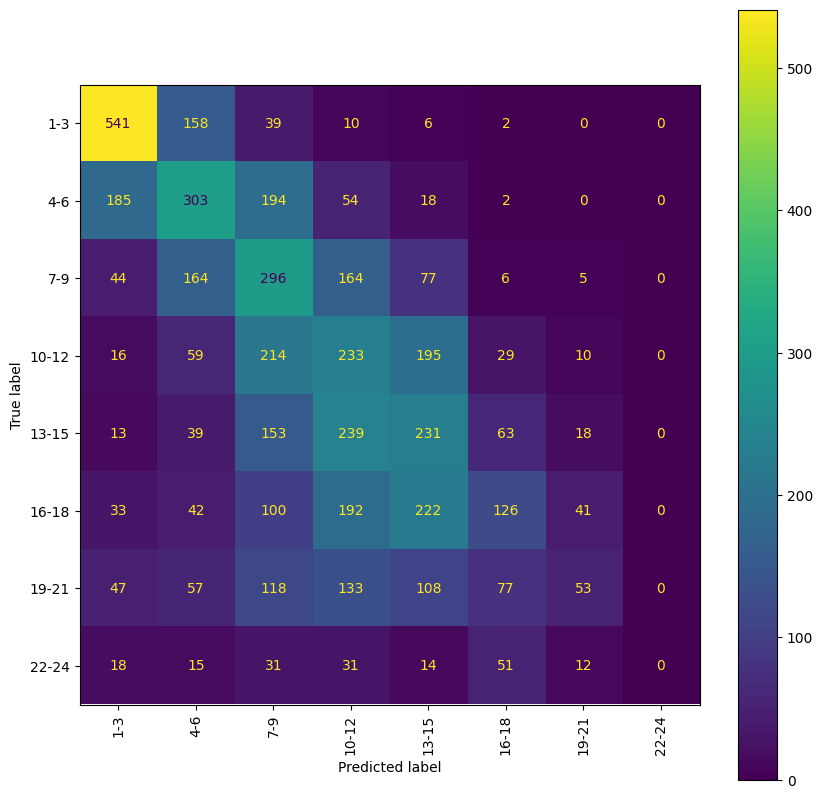

In [39]:
tree = DecisionTreeClassifier(max_depth=4, criterion="entropy")
model_test(tree, X, y, tscv, n_repeats=5, labels=intervals)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=10) ================================================== 

CV with balanced_accuracy: 0.3052460463758562
CV with f1_micro: 0.32359398624181906

               precision    recall  f1-score   support

         1-3       0.53      0.76      0.62       756
         4-6       0.32      0.34      0.33       756
         7-9       0.28      0.31      0.29       756
       10-12       0.22      0.24      0.23       756
       13-15       0.26      0.26      0.26       756
       16-18       0.30      0.35      0.32       756
       19-21       0.25      0.05      0.09       593
       22-24       0.00      0.00      0.00       172

    accuracy                           0.33      5301
   macro avg       0.27      0.29      0.27      5301
weighted avg       0.30      0.33      0.30      5301



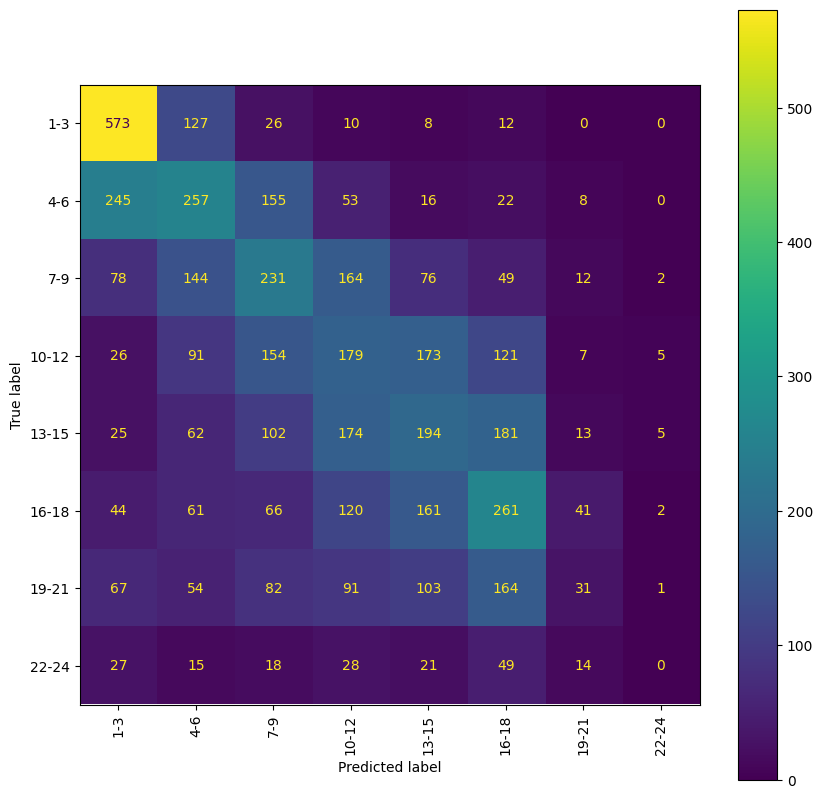

In [40]:
random_forest = RandomForestClassifier(
    n_estimators=10, max_depth=4, criterion="entropy"
)
model_test(random_forest, X, y, tscv, n_repeats=5, labels=intervals)

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 4)) ================================================== 

CV with balanced_accuracy: 0.13598901098901095
CV with f1_micro: 0.14335154335154335

               precision    recall  f1-score   support

         1-3       0.00      0.00      0.00       756
         4-6       0.15      0.09      0.11       756
         7-9       0.15      0.21      0.17       756
       10-12       0.13      0.24      0.17       756
       13-15       0.14      0.23      0.17       756
       16-18       0.15      0.23      0.18       756
       19-21       0.00      0.00      0.00       593
       22-24       0.00      0.00      0.00       172

    accuracy                           0.14      5301
   macro avg       0.09      0.12      0.10      5301
weighted avg       0.10      0.14      0.12      5301



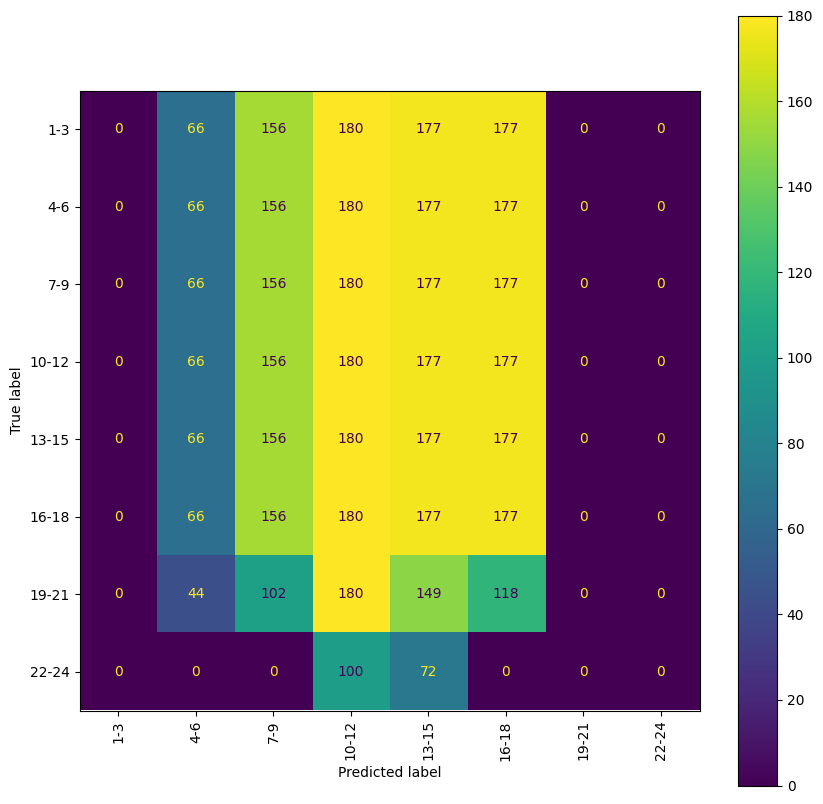

In [41]:
nn = MLPClassifier(hidden_layer_sizes=(30, 4), activation="logistic")
model_test(nn, X, y, tscv, n_repeats=5, labels=intervals)

The fourth objective attribute to be addressed will be if the driver is winner or not.


In [42]:
labels = np.array(["not_winner", "winner"])
winners = df[df["positionFinal"] == 1][["raceYear", "raceRound", "driverRef"]]
y = df.merge(winners, how="left", on=["raceYear", "raceRound"], suffixes=("", "Winner"))
y = y.apply(lambda x: x["driverRef"] == x["driverRefWinner"], axis=1)

KNeighborsClassifier(metric='manhattan', n_neighbors=3) ================================================== 

CV with balanced_accuracy: 0.5030933270552093
CV with f1_micro: 0.9432195039702778

               precision    recall  f1-score   support

  not_winner       0.95      0.99      0.97      5049
      winner       0.08      0.02      0.03       252

    accuracy                           0.94      5301
   macro avg       0.51      0.50      0.50      5301
weighted avg       0.91      0.94      0.93      5301



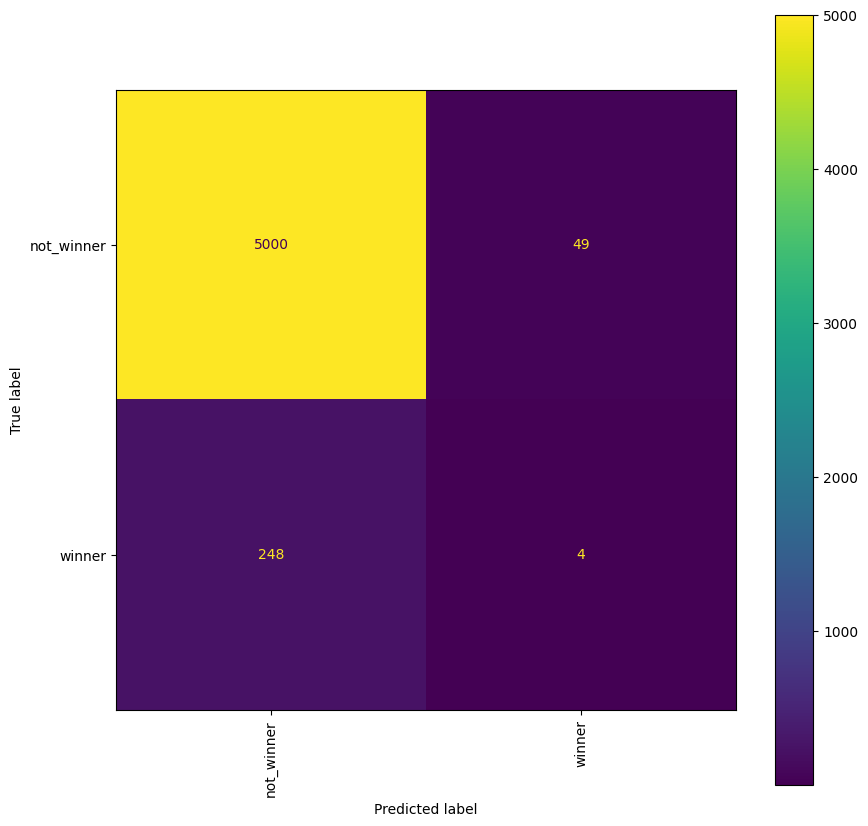

In [43]:
knn = KNeighborsClassifier(n_neighbors=3, metric="manhattan")
model_test(knn, X, y, tscv, labels=labels)

DecisionTreeClassifier(max_depth=2) ================================================== 

CV with balanced_accuracy: 0.8052677343688921
CV with f1_micro: 0.9546189324130501

               precision    recall  f1-score   support

  not_winner       0.98      0.97      0.98      5049
      winner       0.52      0.63      0.57       252

    accuracy                           0.95      5301
   macro avg       0.75      0.80      0.77      5301
weighted avg       0.96      0.95      0.96      5301



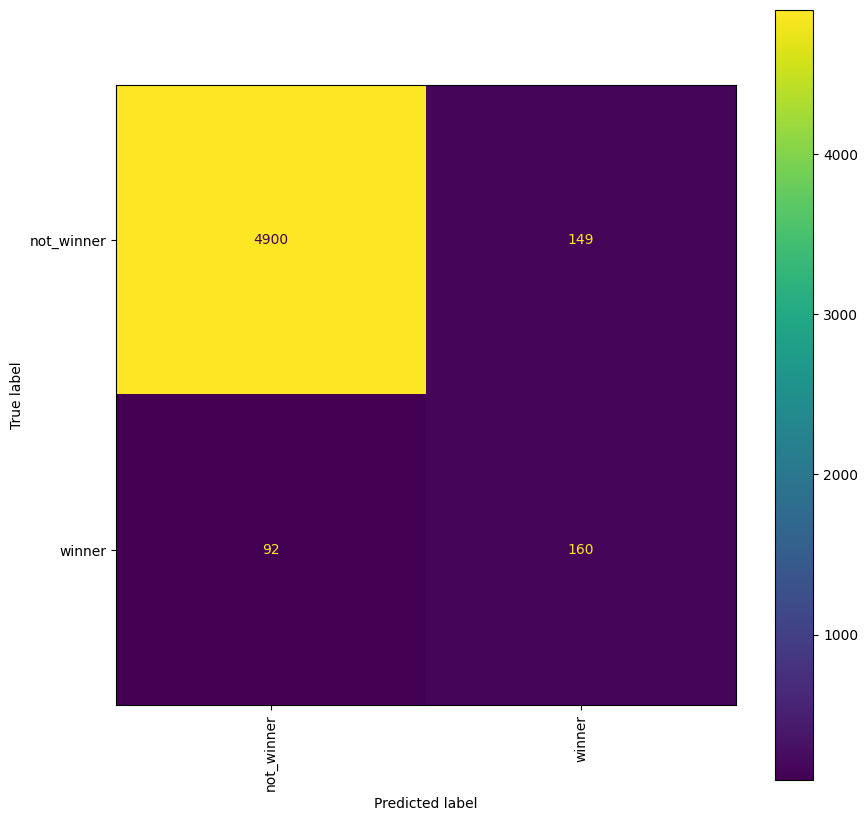

In [44]:
tree = DecisionTreeClassifier(max_depth=2, criterion="gini")
model_test(tree, X, y, tscv, n_repeats=5, labels=labels)

RandomForestClassifier(max_depth=8, n_estimators=5) ================================================== 

CV with balanced_accuracy: 0.6798198292597566
CV with f1_micro: 0.9561028157049828

               precision    recall  f1-score   support

  not_winner       0.97      0.99      0.98      5049
      winner       0.55      0.36      0.43       252

    accuracy                           0.96      5301
   macro avg       0.76      0.67      0.70      5301
weighted avg       0.95      0.96      0.95      5301



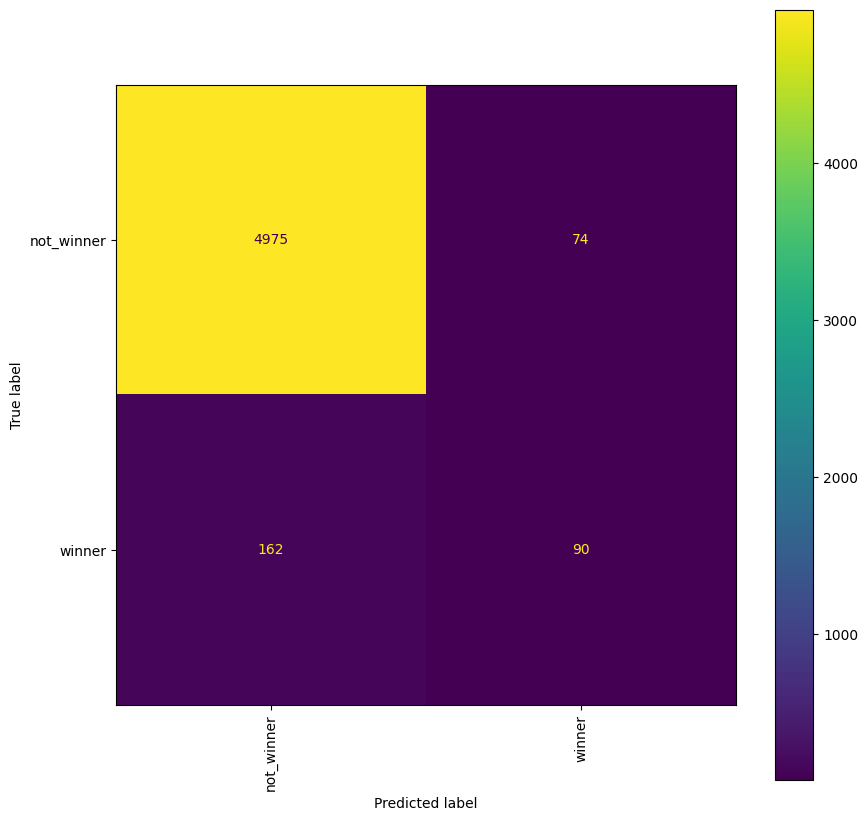

In [45]:
random_forest = RandomForestClassifier(n_estimators=5, max_depth=8, criterion="gini")
model_test(random_forest, X, y, tscv, n_repeats=5, labels=labels)

MLPClassifier(activation='identity', hidden_layer_sizes=10) ================================================== 

CV with balanced_accuracy: 0.5007256933002376
CV with f1_micro: 0.9018406767570856

               precision    recall  f1-score   support

  not_winner       0.95      0.98      0.96      5049
      winner       0.04      0.02      0.03       252

    accuracy                           0.93      5301
   macro avg       0.50      0.50      0.50      5301
weighted avg       0.91      0.93      0.92      5301



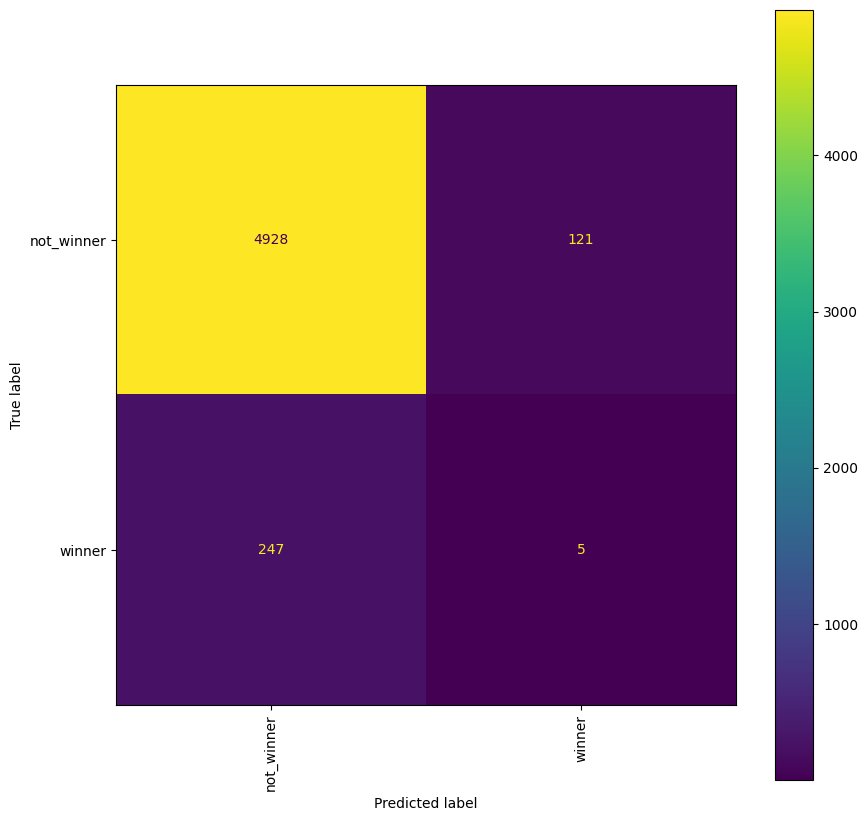

In [46]:
nn = MLPClassifier(hidden_layer_sizes=(10), activation="identity")
model_test(nn, X, y, tscv, n_repeats=5, labels=labels)

The fifth objective attribute to be addressed will be if the driver is podium or not.


In [47]:
labels = np.array(["not_podium", "podium"])
podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: x["driverRef"] in x["driverRefPodium"], axis=1)

KNeighborsClassifier(metric='manhattan', n_neighbors=3) ================================================== 

CV with balanced_accuracy: 0.5798961442245953
CV with f1_micro: 0.7285798304683754

               precision    recall  f1-score   support

  not_podium       0.88      0.79      0.84      4545
      podium       0.23      0.37      0.28       756

    accuracy                           0.73      5301
   macro avg       0.56      0.58      0.56      5301
weighted avg       0.79      0.73      0.76      5301



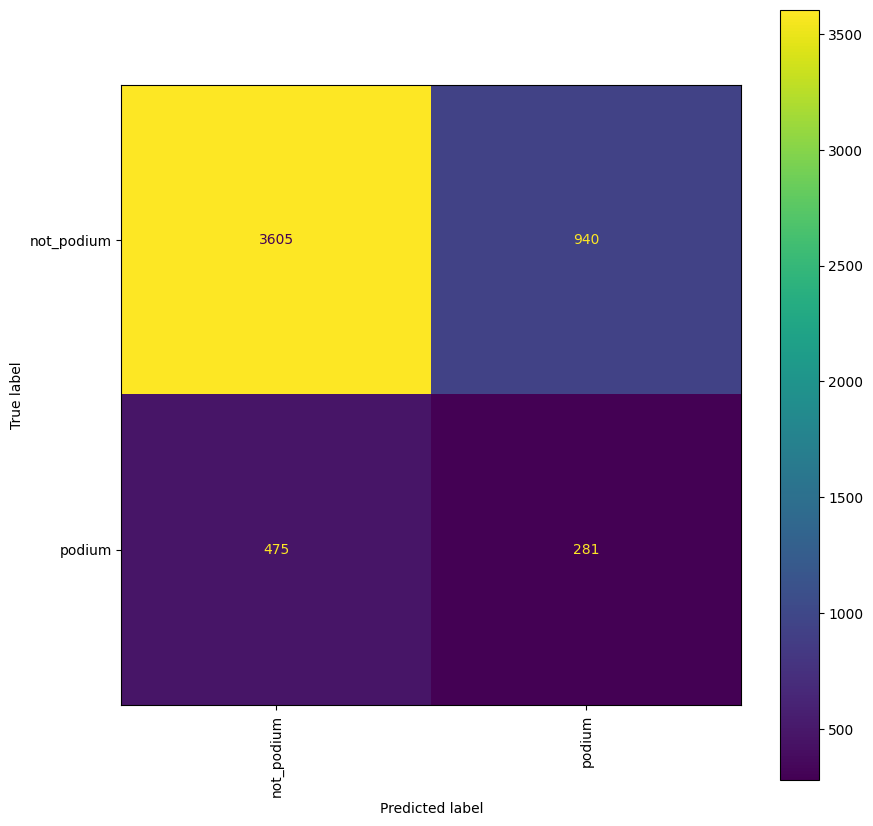

In [48]:
knn = KNeighborsClassifier(n_neighbors=3, metric="manhattan")
model_test(knn, X, y, tscv, labels=labels)

DecisionTreeClassifier(max_depth=2) ================================================== 

CV with balanced_accuracy: 0.7825250937857001
CV with f1_micro: 0.9074239761197965

               precision    recall  f1-score   support

  not_podium       0.94      0.96      0.95      4545
      podium       0.70      0.61      0.65       756

    accuracy                           0.91      5301
   macro avg       0.82      0.78      0.80      5301
weighted avg       0.90      0.91      0.90      5301



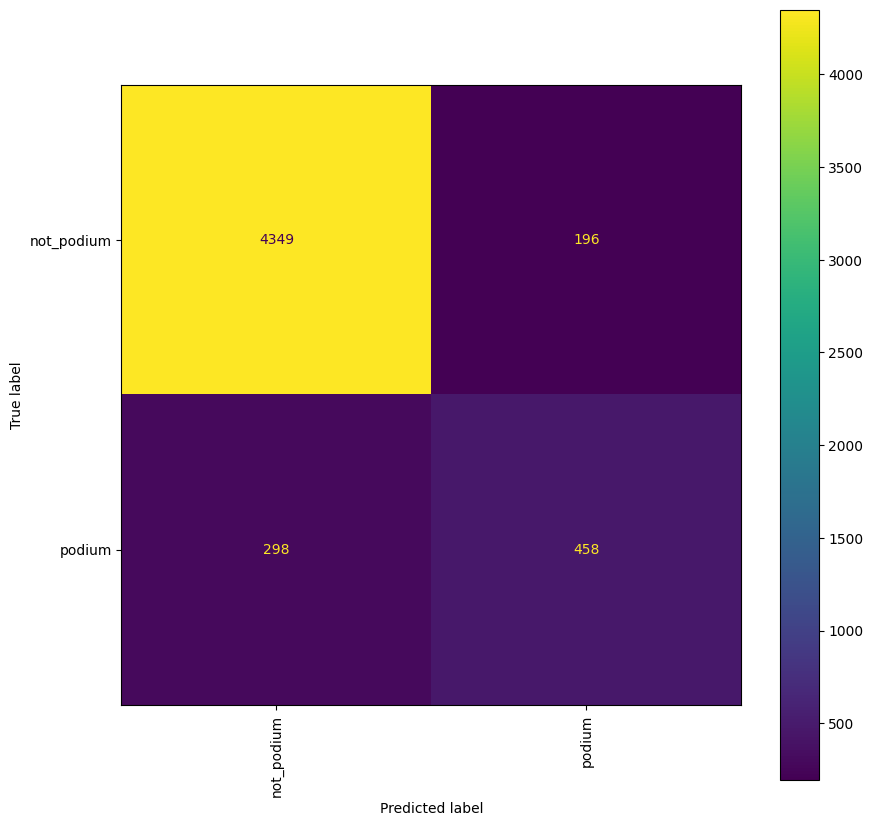

In [49]:
tree = DecisionTreeClassifier(max_depth=2, criterion="gini")
model_test(tree, X, y, tscv, n_repeats=5, labels=labels)

RandomForestClassifier(max_depth=5, n_estimators=7) ================================================== 

CV with balanced_accuracy: 0.7355876541116253
CV with f1_micro: 0.8991428049229908

               precision    recall  f1-score   support

  not_podium       0.92      0.96      0.94      4545
      podium       0.66      0.53      0.59       756

    accuracy                           0.89      5301
   macro avg       0.79      0.74      0.76      5301
weighted avg       0.89      0.89      0.89      5301



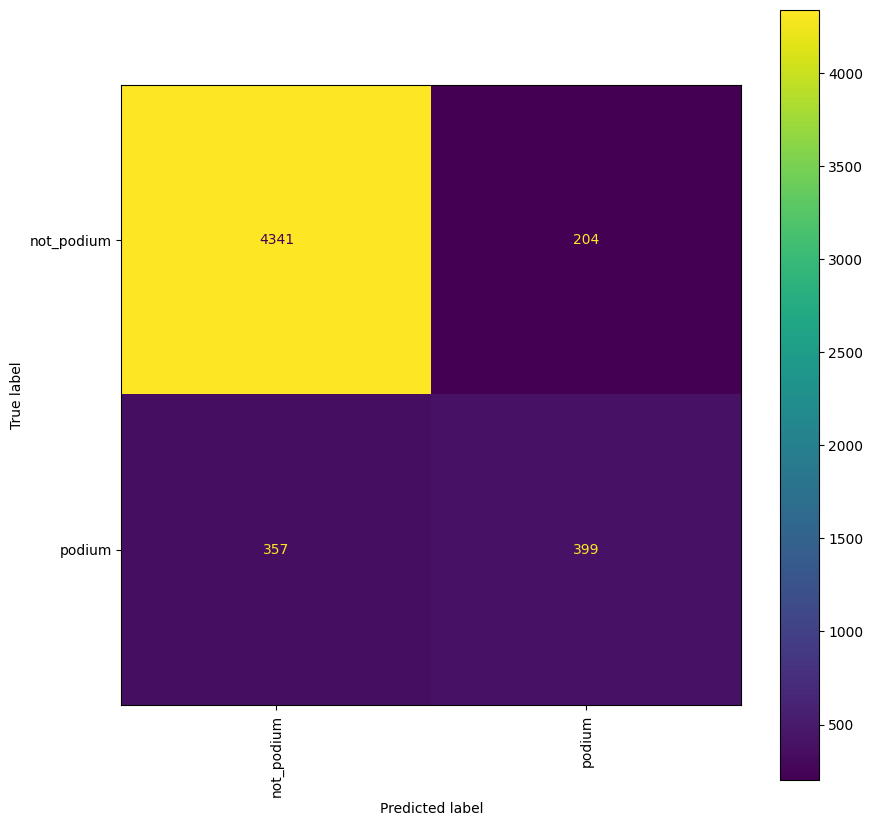

In [50]:
random_forest = RandomForestClassifier(n_estimators=7, max_depth=5, criterion="gini")
model_test(random_forest, X, y, tscv, n_repeats=5, labels=labels)

MLPClassifier(hidden_layer_sizes=(50, 25)) ================================================== 

CV with balanced_accuracy: 0.49976486768893486
CV with f1_micro: 0.7263603558603559

               precision    recall  f1-score   support

  not_podium       0.86      0.79      0.82      4545
      podium       0.15      0.22      0.18       756

    accuracy                           0.71      5301
   macro avg       0.50      0.50      0.50      5301
weighted avg       0.76      0.71      0.73      5301



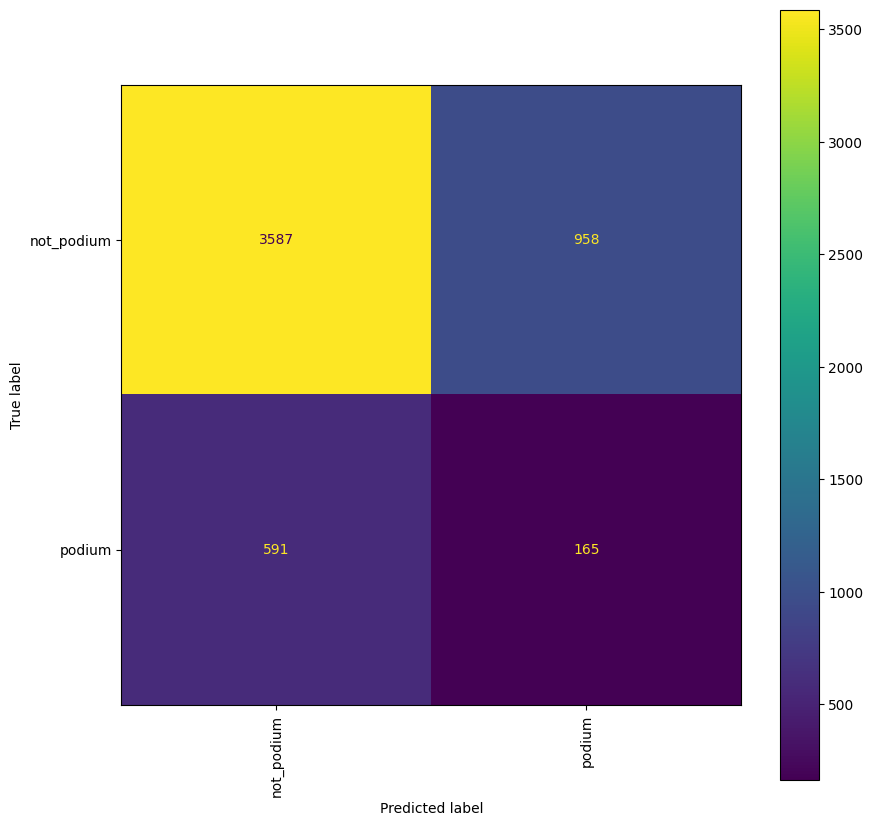

In [51]:
nn = MLPClassifier(hidden_layer_sizes=(50, 25), activation="relu")
model_test(nn, X, y, tscv, n_repeats=5, labels=labels)

TODO:

- 1.- Discuss the target attribute to be analyzed
- 2.- Add more attributes (https://www.ea.com/es-es/games/f1/driver-ratings)???
- 3.- Outliers
- 4.- Simple Hyperparam Tuning (randomsearch, gridsearch)
- 5.- Feature Selection (SequentialForwardSelector:mlxtend, PermutacionImportance, GA, PSO, ...)
- 6.- Hyperparam Tuning with already selected features with bayes (optuna, hyperopt) or others (GA, PSO, ...)
